In [19]:
""" Symbolically solve the system of equations to express everything in
    [H+]. Then, use the numerical solver to just find pH. This vastly reduces
    the LUT size. 
"""
import sympy as sp

# Define the symbolic variables
h, oh, hco3, co3, ca, mg, na, k, al = sp.symbols('h oh hco3 co3 ca mg na k al')

# Define the parameters
b0, co2_atm, beta_h, beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5 = sp.symbols('b0 co2_atm beta_h beta1 beta2 beta3 beta4 beta5 kex1 kex2 kex3 kex4 kex5')
valence_Ca2, valence_Mg2, valence_Na, valence_K, valence_Al3 = sp.symbols('valence_Ca2 valence_Mg2 valence_Na valence_K valence_Al3')

# Define the equations
eq1 = sp.Eq(h * hco3 / co2_atm, 10**(-7.8136))
eq2 = sp.Eq(h * co3 / hco3, 10**(-10.3288))
eq3 = sp.Eq(h * oh, 1e-14)
eq4 = sp.Eq(h / beta_h * (beta1 / ca)**valence_Ca2, kex1)
eq5 = sp.Eq(h / beta_h * (beta2 / mg)**valence_Mg2, kex2)
eq6 = sp.Eq(h / beta_h * (beta3 / na)**valence_Na, kex3)
eq7 = sp.Eq(h / beta_h * (beta4 / k)**valence_K, kex4)
eq8 = sp.Eq(h / beta_h * (beta5 / al)**valence_Al3, kex5)
eq9 = sp.Eq(h - oh - hco3 - 2*co3 + 2*ca + 2*mg + na + k + 3*al, b0)

# Carbonate precipitation constraint
# eq10 = sp.Eq(co3 * ca, 10**(-8.48))

# h - oh - hco3 - 2*co3 + 2*ca + 2*mg + na + k + 3*al + nh4 - no3 - 2*so4 - cl = 0

# E/P | ET/P ratio => Anions become more concentrated

# Solve the equations symbolically for the unknowns in terms of h
solutions = sp.solve((eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9), (oh, hco3, co3, ca, mg, na, k, al))

# Display the solutions
solutions

[(1.0e-14/h,
  1.53603106838503e-8*co2_atm/h,
  7.20443620415286e-19*co2_atm/h**2,
  beta1/(beta_h*kex1/h)**(1/valence_Ca2),
  beta2/(beta_h*kex2/h)**(1/valence_Mg2),
  beta3/(beta_h*kex3/h)**(1/valence_Na),
  beta4/(beta_h*kex4/h)**(1/valence_K),
  0.333333333333333*b0 - 0.666666666666667*beta1/(beta_h*kex1/h)**(1/valence_Ca2) - 0.666666666666667*beta2/(beta_h*kex2/h)**(1/valence_Mg2) - 0.333333333333333*beta3/(beta_h*kex3/h)**(1/valence_Na) - 0.333333333333333*beta4/(beta_h*kex4/h)**(1/valence_K) + 5.12010356128343e-9*co2_atm/h + 4.80295746943524e-19*co2_atm/h**2 - 0.333333333333333*h + 3.33333333333333e-15/h)]

In [ ]:
solutions[-1][-1]

In [ ]:
# Calculate the derivative of the net charge balance
objective_expr = 0.333333333333333*b0 - 0.666666666666667*beta1/((1-beta1-beta2-beta3-beta4-beta5)*kex1/h)**(1/valence_Ca2) - 0.666666666666667*beta2/((1-beta1-beta2-beta3-beta4-beta5)*kex2/h)**(1/valence_Mg2) - 0.333333333333333*beta3/((1-beta1-beta2-beta3-beta4-beta5)*kex3/h)**(1/valence_Na) - 0.333333333333333*beta4/((1-beta1-beta2-beta3-beta4-beta5)*kex4/h)**(1/valence_K) + 5.12010356128343e-9*co2_atm/h + 4.80295746943524e-19*co2_atm/h**2 - 0.333333333333333*h + 3.33333333333333e-15/h - beta5/((1-beta1-beta2-beta3-beta4-beta5)*kex5/h)**(1/valence_Al3)

[sp.diff(objective_expr, beta1),
 sp.diff(objective_expr, beta2),
 sp.diff(objective_expr, beta3),
 sp.diff(objective_expr, beta4),
 sp.diff(objective_expr, beta5)]

In [ ]:
soil_ph = sp.symbols('soil_ph')

objective_expr = 0.333333333333333*b0 - 0.666666666666667*beta1/(beta_h*kex1/10**(-soil_ph))**(1/valence_Ca2) - 0.666666666666667*beta2/(beta_h*kex2/10**(-soil_ph))**(1/valence_Mg2) - 0.333333333333333*beta3/(beta_h*kex3/10**(-soil_ph))**(1/valence_Na) - 0.333333333333333*beta4/(beta_h*kex4/10**(-soil_ph))**(1/valence_K) + 5.12010356128343e-9*co2_atm/10**(-soil_ph) + 4.80295746943524e-19*co2_atm/10**(-soil_ph)**2 - 0.333333333333333*h + 3.33333333333333e-15/10**(-soil_ph) - beta5/(beta_h*kex5/10**(-soil_ph))**(1/valence_Al3)

print(sp.diff(objective_expr, soil_ph))

## Create the lookup table

This have to be run over a computational node; jupyter note book is extremely slow

In [25]:
valence = {'Ca2+': 2, 'Mg2+': 2, 'Na+': 1, 'K+': 1, 'Al3+': 3}
# site-specific but time-constant parameters
# layer: 1-6, in order
site = 'UC_Davis'
if site == 'UC_Davis':
    co2_atm = 360.7 * 1e-6

    # net charge
    b0 = [-2.853672E-05, -2.860919E-05, -2.807959E-05, -2.936564E-05, -2.901754E-05, 3.264181E-05]

    # net charge from SO4 = 0.4 mg/L, NO3 = 0.6 mg/L, Cl- = 0.6 mg/L, NH4+ = 0.5 mg/L
    b0_rain = - 0.4e-3 / 96.0626 * 2 - 0.6e-3 / 62.0049 - 0.6e-3 / 35.4530 + 0.5e-3 / 18
    # = -7.15e-6 mol/L
    b0 = [item*(-1) for item in b0]

    log_kex1 = [-3.21539525,-3.212338935,-3.234160937,-3.399993609,-3.415958436,-3.649390287]
    log_kex2 = [-3.547076115,-3.543709241,-3.567752631,-3.665263214,-3.682446901,-3.904912927]
    log_kex3 = [-3.006006528,-3.003143469,-3.023580729,-2.797460878,-2.810560926,-3.433079721]
    log_kex4 = [-1.712732987,-1.711128621,-1.72260382,-1.767368466,-1.77560023,-2.187599601]
    log_kex5 = [-3.003082584,-3.000268548,-3.020395062,-2.939311817,-2.953001418,-3.834911007]

    actual_beta = [
        
    ]
else:
    co2_atm = 284.7 * 1e-6
    b0 = [0.489029607715217, 0.0308578569443786, 0.226528886879802, 0.0620675682607074, 0.120671900612362, 188.97469508801]

    # net charge from SO4 = 1.5 mg/L, NO3 = 1.4 mg/L, Cl- = 0.1 mg/L, NH4+ = 0.15 mg/L
    b0_rain = - 1.5e-3 / 96.0626 * 2 - 1.4e-3 / 62.0049 - 0.1e-3 / 35.4530 + 0.15e-3 / 18
    # = -4.82e-05 mol/L
    # magnitude is different, but perhaps due to negatively charged SOM?

    log_kex1 = [-2.925801906,-2.703094316,-3.068503498,-3.22213221,-3.331887122,-3.592478657]
    log_kex2 = [-3.278352155,-2.990880917,-3.382389992,-3.509536635,-3.628444259,-3.869019892]
    log_kex3 = [-2.677634403,-2.527997407,-2.88802672,-2.894696967,-2.993081802,-3.523791902]
    log_kex4 = [-1.850722189,-1.58358967,-1.755040337,-1.700634683,-1.75675787,-2.167948533]
    log_kex5 = [-3.239715574,-2.788045794,-3.09571289,-3.176810038,-3.283124237,-4.274853507]

    actual_beta = [
        
    ]

In [ ]:
# from scipy.optimize import minimize
import numpy as np
import itertools as it
from tqdm import tqdm
import multiprocessing as mp

def objective(
    soil_ph,
    b0, co2_atm, beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5
):
    h = 10**(-soil_ph)
    beta_h = 1 - beta1 - beta2 - beta3 - beta4 - beta5

    al_RHS = 1/3*(b0 - 2*beta1/(beta_h*kex1/h)**(1/valence['Ca2+']) - 2*beta2/(beta_h*kex2/h)**(1/valence['Mg2+']) - beta3/(beta_h*kex3/h)**(1/valence['Na+']) - beta4/(beta_h*kex4/h)**(1/valence['K+']) + 1.53603106838503e-8*co2_atm/h + 7.20443620415286e-19*co2_atm/h**2 - h + 1e-14/h)
    al_LHS = beta5/(beta_h*kex5/h)**(1/valence['Al3+'])

    return abs(al_RHS - al_LHS) / (0.5*abs(al_RHS) + 0.5*abs(al_LHS))


def objective_numeratorDerive(
    soil_ph,
    beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5        
): 
    """ calculate the derivative of the objective's numerator w.r.t. beta1-5 and soil pH"""
    h = 10**(-soil_ph)
    beta_h = 1 - beta1 - beta2 - beta3 - beta4 - beta5

    dojb_dbeta = [
       -0.666666666666667*beta1/(valence['Ca2+']*(kex1*beta_h/h)**(1/valence['Ca2+'])*beta_h) - 0.666666666666667*beta2/(valence['Mg2+']*(kex2*beta_h/h)**(1/valence['Mg2+'])*beta_h) - 0.333333333333333*beta3/(valence['Na+']*(kex3*beta_h/h)**(1/valence['Na+'])*beta_h) - 0.333333333333333*beta4/(valence['K+']*(kex4*beta_h/h)**(1/valence['K+'])*beta_h) - beta5/(valence['Al3+']*(kex5*beta_h/h)**(1/valence['Al3+'])*beta_h) - 0.666666666666667/(kex1*beta_h/h)**(1/valence['Ca2+']),
       -0.666666666666667*beta1/(valence['Ca2+']*(kex1*beta_h/h)**(1/valence['Ca2+'])*beta_h) - 0.666666666666667*beta2/(valence['Mg2+']*(kex2*beta_h/h)**(1/valence['Mg2+'])*beta_h) - 0.333333333333333*beta3/(valence['Na+']*(kex3*beta_h/h)**(1/valence['Na+'])*beta_h) - 0.333333333333333*beta4/(valence['K+']*(kex4*beta_h/h)**(1/valence['K+'])*beta_h) - beta5/(valence['Al3+']*(kex5*beta_h/h)**(1/valence['Al3+'])*beta_h) - 0.666666666666667/(kex2*beta_h/h)**(1/valence['Mg2+']),
       -0.666666666666667*beta1/(valence['Ca2+']*(kex1*beta_h/h)**(1/valence['Ca2+'])*beta_h) - 0.666666666666667*beta2/(valence['Mg2+']*(kex2*beta_h/h)**(1/valence['Mg2+'])*beta_h) - 0.333333333333333*beta3/(valence['Na+']*(kex3*beta_h/h)**(1/valence['Na+'])*beta_h) - 0.333333333333333*beta4/(valence['K+']*(kex4*beta_h/h)**(1/valence['K+'])*beta_h) - beta5/(valence['Al3+']*(kex5*beta_h/h)**(1/valence['Al3+'])*beta_h) - 0.333333333333333/(kex3*beta_h/h)**(1/valence['Na+']),
       -0.666666666666667*beta1/(valence['Ca2+']*(kex1*beta_h/h)**(1/valence['Ca2+'])*beta_h) - 0.666666666666667*beta2/(valence['Mg2+']*(kex2*beta_h/h)**(1/valence['Mg2+'])*beta_h) - 0.333333333333333*beta3/(valence['Na+']*(kex3*beta_h/h)**(1/valence['Na+'])*beta_h) - 0.333333333333333*beta4/(valence['K+']*(kex4*beta_h/h)**(1/valence['K+'])*beta_h) - beta5/(valence['Al3+']*(kex5*beta_h/h)**(1/valence['Al3+'])*beta_h) - 0.333333333333333/(kex4*beta_h/h)**(1/valence['K+']),
       -0.666666666666667*beta1/(valence['Ca2+']*(kex1*beta_h/h)**(1/valence['Ca2+'])*beta_h) - 0.666666666666667*beta2/(valence['Mg2+']*(kex2*beta_h/h)**(1/valence['Mg2+'])*beta_h) - 0.333333333333333*beta3/(valence['Na+']*(kex3*beta_h/h)**(1/valence['Na+'])*beta_h) - 0.333333333333333*beta4/(valence['K+']*(kex4*beta_h/h)**(1/valence['K+'])*beta_h) - beta5/(valence['Al3+']*(kex5*beta_h/h)**(1/valence['Al3+'])*beta_h) - 1/(kex5*beta_h/h)**(1/valence['Al3+'])]

    dojb_dsoil_ph = 5.12010356128343e-9*10**soil_ph*co2_atm*np.log(10) + 3.33333333333333e-15*10**soil_ph*np.log(10) + 0.666666666666667*beta1*np.log(10)/(valence['Ca2+']*(10**soil_ph*beta_h*kex1)**(1/valence['Ca2+'])) + 0.666666666666667*beta2*np.log(10)/(valence['Mg2+'])*(10**soil_ph*beta_h*kex2)**(1/valence['Mg2+']) + 0.333333333333333*beta3*np.log(10)/(valence['Na+']*(10**soil_ph*beta_h*kex3)**(1/valence['Na+'])) + 0.333333333333333*beta4*np.log(10)/(valence['K+']*(10**soil_ph*beta_h*kex4)**(1/valence['K+'])) + beta5*np.log(10)/(valence['Al3+']*(10**soil_ph*beta_h*kex5)**(1/valence['Al3+'])) - 9.60591493887048e-19*co2_atm*soil_ph*np.log(10)/10**(soil_ph**2)

    return dojb_dbeta + [dojb_dsoil_ph]


def find_solution(args):
    try:
        layerid = args[-2]
        betaid = args[-1]
        args = args[:-2]

        # print(betaid)

        # use a simple grid search to find the correct pH
        grid_search = np.linspace(0.5, 13.5, 501)

        count = 0
        err = 1
        while (err > 1e-3) and (count < 100):
            obj_value = []
            for soil_ph in grid_search:
                obj_value.append(objective(soil_ph, *args))
            best = np.argmin(np.abs(obj_value))

            # the best point is not guaranteeed to be between
            # the best and the second best when the mesh is
            # too coarse! 
            # arr = np.delete(np.abs(obj_value), best)
            # second_best = np.argmin(arr)
            # if second_best >= best:
            #     second_best = second_best + 1
            # best = grid_search[best]
            # second_best = grid_search[second_best]

            best_left = grid_search[max(best-5, 0)]
            best_right = grid_search[min(best+5, len(grid_search)-1)]
            best = grid_search[best]

            # print(best)

            err = objective(best, *args)

            grid_search = np.linspace(best_left, best_right, 501 + int(501*err))
            count = count + 1

            # DEBUG
            # print(count, err, best_left, best_right)

        return (best, err, count, layerid, betaid)
    except:
        print(layerid, betaid)
        raise

In [ ]:
# Create the parameter ranges to search over
layer_list = range(1, 7)

#beta1_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta2_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta3_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta4_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta5_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
beta1_grid = np.concatenate((np.arange(0.01, 0.11, 0.01), 
                             np.arange(0.15, 1, 0.05)))
beta2_grid = np.concatenate((np.arange(0.01, 0.11, 0.01), 
                             np.arange(0.15, 1, 0.05)))
beta3_grid = np.concatenate((np.arange(0.01, 0.11, 0.01), 
                             np.arange(0.15, 1, 0.05)))
beta4_grid = np.concatenate((np.arange(0.01, 0.11, 0.01), 
                             np.arange(0.15, 1, 0.05)))
beta5_grid = np.concatenate((np.arange(0.01, 0.11, 0.01), 
                             np.arange(0.15, 1, 0.05)))

grid_values = []
for beta1, beta2, beta3, beta4, beta5 in \
    it.product(beta1_grid, beta2_grid, beta3_grid, beta4_grid, beta5_grid):
    # can't set to 1; that causes floating point precision problems
    if (beta1 + beta2 + beta3 + beta4 + beta5) < 0.95:
        index = int(np.around(beta1/0.01) * 1e8 + np.around(beta2/0.01) * 1e6 + \
            np.around(beta3/0.01) * 1e4 + np.around(beta4/0.01) * 1e2 + \
            np.around(beta5/0.01))
        grid_values.append([index, beta1, beta2, beta3, beta4, beta5])

# Create the list of arguments to run the root finding code
args_list = []
for (i, layer), (j, (_, beta1, beta2, beta3, beta4, beta5)) in \
    it.product(enumerate(layer_list), enumerate(grid_values)):

    args = b0[layer-1], co2_atm, beta1, beta2, beta3, beta4, beta5, \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1], i, j

    args_list.append(args)

# Collect the results
p = mp.Pool(mp.cpu_count())
# results = p.map_async(find_solution, args_list)
results = list(tqdm(p.imap(find_solution, args_list), total=len(args_list)))
p.close()
p.join()

# best pH
solved_pH = np.full([len(grid_values), len(layer_list)], np.nan)
# err relative to 0
solved_err = np.full([len(grid_values), len(layer_list)], np.nan)
# number of iterations the solver took
solved_iter = np.full([len(grid_values), len(layer_list)], np.nan)
# acid saturation; I guess this may be related to err
beta_h = np.full([len(grid_values), len(layer_list)], np.nan) 
for rs in results:
    j = rs[-1] # betaid
    i = rs[-2] # layerid
    solved_pH[j,i] = rs[0]
    solved_err[j,i] = rs[1]
    solved_iter[j,i] = rs[2]
    beta_h[j,i] = 1 - sum(grid_values[j][1:])

In [ ]:
# Diagnostic plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_pH[:, i])
fig.savefig('solved_pH.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_err[:, i])
fig.savefig('solved_err.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_iter[:, i])
fig.savefig('solved_iter.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(3, 2, figsize = (20,20))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(beta_h[:, i], solved_err[:, i], 'o')
fig.savefig('solved_betaherr.png', dpi = 600.)
plt.close(fig)

In [ ]:
# Save the LUT
import os
import pandas as pd

LUT = pd.DataFrame(
    np.hstack([np.array(grid_values), solved_pH]), 
    columns = ['grid_id', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 
               'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
)
LUT = LUT.set_index('grid_id')
LUT.index = LUT.index.astype(int)
LUT.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', f'dynpH_LUT_{site}.csv'))

In [ ]:
""" Worker code; only for checking why things are bad
"""

"""import matplotlib.pyplot as plt

layer = 6
i = layer-1
bad = 0 # np.where(solved_err[:, layer-1] > 0.5)[0][0]
j, beta1, beta2, beta3, beta4, beta5 = grid_values[bad]

print(beta1, beta2, beta3, beta4, beta5)

args = b0[layer-1], co2_atm, beta1, beta2, beta3, beta4, beta5, \
       10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
       10**log_kex4[layer-1], 10**log_kex5[layer-1], i, j
result = find_solution(args)
result

soil_ph = np.linspace(0.5, 0.75, 101)
val = objective(soil_ph, *args[:-2])
plt.plot(soil_ph, val)"""

## Test the accuracy of the LUT by randomly picking some values

In [20]:
from scipy.stats.qmc import LatinHypercube
import pandas as pd
import os
import numpy as np
import itertools as it
import math
import matplotlib.pyplot as plt

eps = 0.01
npts = LatinHypercube(5, seed = 125).random(n = 10000)
npts = np.array([npts[i,:] for i in range(npts.shape[0]) if (np.sum(npts[i,:]) <= 0.95) & \
                (np.min(npts[i,:]) >= eps)])
LUT = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                               f'dynpH_LUT_{site}.csv'),index_col = 0)

In [21]:
LUT

,beta1,beta2,beta3,beta4,beta5,layer1,layer2,layer3,layer4,layer5,layer6
grid_id,,,,,,,,,,,
101010101,0.01,0.01,0.01,0.01,0.01,8.126062,8.125588,8.131371,8.127500,8.131867,8.335769
101010102,0.01,0.01,0.01,0.01,0.02,8.313774,8.313050,8.318891,8.307349,8.311000,8.524193
101010103,0.01,0.01,0.01,0.01,0.03,8.433347,8.432579,8.437856,8.423882,8.427421,8.643118
101010104,0.01,0.01,0.01,0.01,0.04,8.521274,8.520500,8.525637,8.509809,8.513363,8.730000
101010105,0.01,0.01,0.01,0.01,0.05,8.590872,8.590111,8.595105,8.578383,8.581889,8.798359
...,...,...,...,...,...,...,...,...,...,...,...
8505010102,0.85,0.05,0.01,0.01,0.02,9.185120,9.184175,9.190929,9.233703,9.238643,9.331126
8505010201,0.85,0.05,0.01,0.02,0.01,9.163888,9.162920,9.169831,9.216657,9.221677,9.306216
8505020101,0.85,0.05,0.02,0.01,0.01,9.163896,9.162929,9.169831,9.216657,9.221677,9.306225


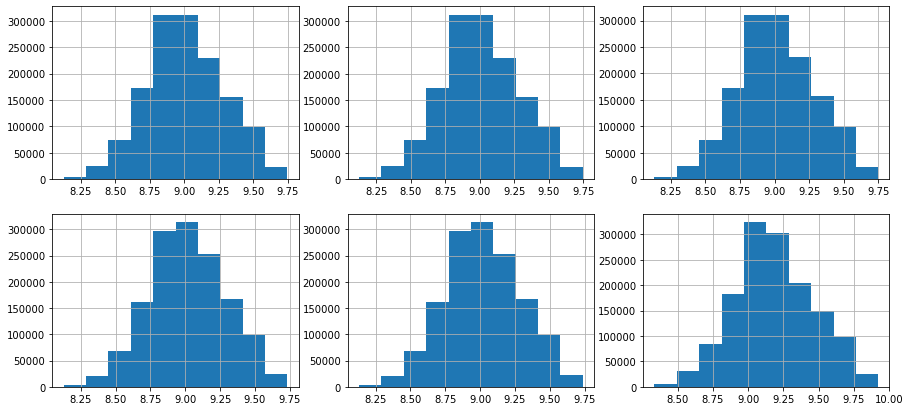

In [22]:
fig, axes = plt.subplots(2, 3, figsize = (15, 7))
for i in range(6):
    ax = axes.flat[i]
    LUT[f'layer{i+1}'].hist(ax = ax)

In [26]:
beta1 = LUT.iloc[0, 0]
beta_h = 1 - LUT.iloc[0, :5].sum()
kex1 = 10**log_kex1[0]
h = 10**(-LUT.iloc[0, :]['layer1'])
print(beta1, beta_h, h)

beta1/(beta_h*kex1/h)**(1/valence['Ca2+']), 7.20443620415286e-19*co2_atm/h**2

0.01 0.95 7.48062672545529e-09


(3.595876889851582e-05, 4.643764351899025e-06)

In [ ]:
def pentainear_interpolate(grid_pts, grid_dist, grid_vals):
    """
    Inputs:
    grid_pts - binary number ijkmn, indicates which side
    grid_dist - distance to the lower and upper bounds in grid_pts
    grid_vals - the values at the locations indicated by grid_pts
    """
    # gradually reduce the dimensions

    prev_pts = grid_pts.copy()
    prev_dist = grid_dist.copy()
    prev_interp = grid_vals.copy()

    for bit_position in range(5): # bit position counting from the right

        # find the lower bounds
        bitmask = 1 << bit_position
        left_filter = np.where([not (pg&bitmask) for pg in prev_pts])[0]
        right_filter = np.where([pg&bitmask for pg in prev_pts])[0]

        new_interp = []
        for i in left_filter:
            left = prev_pts[i]
            # check if there is a corresponding upper bound
            right = left^(0 << bit_position)
            temp = np.where([pt == right for pt in prev_pts[right_filter]])[0]
            if len(temp) == 1:
                left_weight = prev_dist[i, 4-bit_position]
                right_weight = prev_dist[right_filter[temp[0]], 4-bit_position]

                left_val = prev_interp[i]
                right_val = prev_interp[right_filter[temp[0]]]

                new_interp.append((left_val*left_weight+right_val*right_weight) / \
                                  (left_weight + right_weight))
            elif len(temp) == 0:
                new_interp.append(prev_interp[i])
            else:
                raise Exception('Too many matching upper bounds')

        prev_pts = prev_pts[left_filter]
        prev_dist = prev_dist[left_filter]
        prev_interp = new_interp
    
    if len(prev_interp) > 1:
        raise Exception('Not boiled down to a single number')

    return prev_interp[0]


def apply_LUT(layer, beta_list):
    # note: subtract the minimum offset
    column = f'layer{layer}'

    beta_grid = np.concatenate((np.arange(0.01, 0.11, 0.01), 
                                np.arange(0.15, 1, 0.05)))
    pt_low_high = np.empty([5,2], dtype=float)
    for i in range(5):
        # add eps to avoid 1 being recognized as 0.9999999999999999999
        pt_low_high[i,0] = beta_grid[np.max(np.where(beta_grid <= (beta_list[i]+1e-6))[0])]
        pt_low_high[i,1] = beta_grid[np.min(np.where(beta_grid > (beta_list[i]+1e-6))[0])]

    # Get all the nearby points
    grid_pts = [] # indicate low or high end
    grid_dist = [] # distance from the actual point
    grid_vals = [] # values at the points
    for i,j,k,m,n in it.product(range(2), range(2), range(2), range(2), range(2)):
        pt = np.array([pt_low_high[0,i], pt_low_high[1,j], pt_low_high[2,k], \
                       pt_low_high[3,m], pt_low_high[4,n]])
        if np.sum(pt) >= 0.95:
            continue # exclude out of range boundaries
        grid_pts.append(int(f"{i}{j}{k}{m}{n}", 2))
        grid_dist.append(np.abs(np.array(beta_list) - pt))
        pt_int = np.around(pt/0.01).astype(int)
        index = pt_int[0] * 1e8 + pt_int[1] * 1e6 + pt_int[2] * 1e4 + pt_int[3] * 1e2 + pt_int[4]
        grid_vals.append(LUT.loc[index, column])
    grid_pts = np.array(grid_pts)
    grid_dist = np.array(grid_dist)
    grid_vals = np.array(grid_vals)

    result = pentainear_interpolate(grid_pts, grid_dist, grid_vals)

    return result

In [ ]:
test_result = np.full([npts.shape[0], 6], np.nan)
test_err = np.full([npts.shape[0], 6], np.nan)
test_correct = np.full([npts.shape[0], 6], np.nan)
for i,j in it.product(range(6), range(npts.shape[0])):
    layer = i + 1
    beta_list = list(npts[j, :])

    result = apply_LUT(layer, beta_list)

    args = b0[layer-1], co2_atm, beta_list[0], beta_list[1], \
           beta_list[2], beta_list[3], beta_list[4], \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1]

    test_result[j,i] = result
    test_err[j,i] = objective(result, *args)
    test_correct[j,i], _, _, _, _ = find_solution(list(args) + [i, j])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    axes.flat[i].plot(test_err[:, i])
fig.savefig('test_err.png', dpi = 600.)

fig, axes = plt.subplots(2, 3, figsize = (15,10))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(test_correct[:, i], test_result[:, i], 'o')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
    ax.set_ylim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])

    # put the observation
    if 'HBR' in site:
        XXX

fig.savefig('test_result.png', dpi = 600.)

In [ ]:
err_deriv = np.full([npts.shape[0], 6, 6], np.nan)
for i,j in it.product(range(6), range(npts.shape[0])):
    layer = i + 1
    beta_list = list(npts[j, :])
    soil_ph = test_result[j, i]

    args = soil_ph, beta_list[0], beta_list[1], \
           beta_list[2], beta_list[3], beta_list[4], \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1]

    err_deriv[j,i, :] = objective_numeratorDerive(*args)

In [ ]:
# Plot the relationship between derivative size and error
fig, axes = plt.subplots(6, 6, figsize = (20, 20))
for i,j in it.product(range(6), range(6)):
    ax = axes[i,j]
    if j < 5:
        ax.plot(err_deriv[:, i, j], test_err[:, i], 'o')
    else:   
        # test the relationship with norm of the gradient?
        ax.plot(np.sum(err_deriv[:, i, :5], axis = 1), test_err[:, i], 'o')
    ax.set_xscale('symlog', linthresh = 1e-3)

In [ ]:
# Plot the relationship between derivative size and beta
fig, axes = plt.subplots(6, 6, figsize = (20, 20))
for i,j in it.product(range(6), range(6)):
    ax = axes[i,j]
    if j < 5:
        ax.plot(npts[:, j], err_deriv[:, i, j], 'o')
    else:
        ax.plot(np.sum(npts, axis = 1), err_deriv[:, i, j], 'o')
    ax.set_yscale('symlog', linthresh = 1e-3)